---
# CSE 151B Project - Linear Model
---

## Install the package dependencies before running this notebook

In [210]:
import torch
from torch.utils.data import Dataset, DataLoader
import os, os.path 
import time
import math
import string
import numpy 
import pickle
from glob import glob

## Use GPU if Available

In [211]:
device = None
if torch.cuda.is_available():
    device = torch.device('cuda')

device

device(type='cuda')

## Create a Torch.Dataset class for the training dataset

In [212]:
from glob import glob
import pickle
import numpy as np

"""
    number of trajectories in each city
    # austin --  train: 43041 test: 6325 
    # miami -- train: 55029 test:7971
    # pittsburgh -- train: 43544 test: 6361
    # dearborn -- train: 24465 test: 3671
    # washington-dc -- train: 25744 test: 3829
    # palo-alto -- train:  11993 test:1686

    trajectories sampled at 10HZ rate, input 5 seconds, output 6 seconds
    
"""

ROOT_PATH = "./"

cities = ["austin", "miami", "pittsburgh", "dearborn", "washington-dc", "palo-alto"]
splits = ["train", "test"]

def get_city_trajectories(city="palo-alto", split="train", normalized=False):

    
    outputs = None
    
    if split=="train":
        f_in = ROOT_PATH + split + "/" + city + "_inputs"
        inputs = pickle.load(open(f_in, "rb"))
        n = len(inputs)
        inputs = np.asarray(inputs)[:int(n * 0.8)]
        
        f_out = ROOT_PATH + split + "/" + city + "_outputs"
        outputs = pickle.load(open(f_out, "rb"))
        outputs = np.asarray(outputs)[:int(n * 0.8)]
        
    elif split == 'val':
        f_in = ROOT_PATH + 'train' + "/" + city + "_inputs"
        inputs = pickle.load(open(f_in, "rb"))
        n = len(inputs)
        inputs = np.asarray(inputs)[int(n * 0.8):]
        
        f_out = ROOT_PATH + 'train' + "/" + city + "_outputs"
        outputs = pickle.load(open(f_out, "rb"))
        outputs = np.asarray(outputs)[int(n * 0.8):]
    
    else:
        f_in = ROOT_PATH + split + "/" + city + "_inputs"
        inputs = pickle.load(open(f_in, "rb"))
        n = len(inputs)
        inputs = np.asarray(inputs)

    return inputs, outputs

class ArgoverseDataset(Dataset):
    """Dataset class for Argoverse"""
    def __init__(self, city: str, split:str, transform=None):
        super(ArgoverseDataset, self).__init__()
        self.transform = transform

        self.inputs = []
        self.outputs = []

        # Include ALL cities in the Dataset
        if (city == 'all'):
            for city_name in cities:
                city_inputs, city_outputs = get_city_trajectories(city=city_name, split=split, normalized=False)
                for i in range(len(city_inputs)):
                    self.inputs.append(city_inputs[i])
                    self.outputs.append(city_outputs[i])
        
        # Only include the city specified
        else:
             self.inputs, self.outputs = get_city_trajectories(city, split=split, normalized=False)

    def __len__(self):
        return len(self.inputs)

    def __getitem__(self, idx):

        data = (self.inputs[idx], self.outputs[idx])
            
        if self.transform:
            data = self.transform(data)

        return data

# intialize training dataset
city = 'all' 
split = 'train'
train_dataset  = ArgoverseDataset(city = city, split = split)

## Create a DataLoader class for training

In [213]:
batch_sz = 100  # batch size 
train_loader = DataLoader(train_dataset,batch_size=batch_sz)

## Define the Linear Model

In [214]:
from torch import nn, optim

class Pred(nn.Module):

    def __init__(self):
        super().__init__()
        
        self.encoder = nn.Sequential(
            nn.Linear(100, 64),
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 32)
        )
        
        self.decoder = nn.Sequential(
            nn.Linear(32, 64),
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, 100),
            nn.ReLU(),
            nn.Linear(100, 120),
            nn.ReLU(),
            nn.Linear(120, 120)
        )
        
    def forward(self, x):
        x = x.reshape(-1, 100).float()
        x = self.encoder(x)
        x = self.decoder(x)
        x = x.reshape(-1, 60, 2)
        return x

In [215]:
pred = Pred().to(device)
opt = optim.Adam(pred.parameters(), lr=1e-5)

## Track the Time for Each Epoch

In [216]:
def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    s = int(s)
    h = math.floor(m / 60)
    m -= h * 60
    return '%sh %sm %ss' % (str(h), str(m).rjust(2, '0'), str(s).rjust(2, '0'))

## Train the Model

In [217]:
num_epochs = 500
all_losses = []

start = time.time()

print('======================================================')
print('|     TIME     | PROGRESS | EPOCH |      LOSS        |')
print('======================================================')

for epoch in range(num_epochs):
    
    total_loss = 0
    for i_batch, sample_batch in enumerate(train_loader):
        inp, out = sample_batch
        inp = inp.to(device)
        out = out.to(device)
        preds = pred(inp)
        loss = ((preds - out) ** 2).sum()
        
        opt.zero_grad()
        loss.backward()
        opt.step()
        
        total_loss += loss.item()

    epoch_loss = total_loss / len(train_dataset)
    train_progress = int(epoch / num_epochs * 100)
        
    # print('epoch {} loss: {}'.format(epoch, total_loss / len(train_dataset)))
    print('   %s  |   %s%%   |  %s  |  %.4f  ' % (timeSince(start), str(train_progress).rjust(3, '0'), str(epoch).rjust(3,'0'), epoch_loss))
    # print('-----------------------------------------------------')
    all_losses.append(epoch_loss)

|     TIME     | PROGRESS | EPOCH |      LOSS        |
   0h 00m 09s  |   000%   |  000  |  404753169.6182  
   0h 00m 19s  |   000%   |  001  |  162812013.7268  
   0h 00m 29s  |   000%   |  002  |  66675109.8485  
   0h 00m 38s  |   000%   |  003  |  28335614.2038  
   0h 00m 48s  |   000%   |  004  |  15657399.8016  
   0h 00m 57s  |   001%   |  005  |  10068307.6148  
   0h 01m 07s  |   001%   |  006  |  6893819.1995  
   0h 01m 17s  |   001%   |  007  |  4666325.4523  
   0h 01m 26s  |   001%   |  008  |  2915863.5943  
   0h 01m 36s  |   001%   |  009  |  1766405.2733  
   0h 01m 46s  |   002%   |  010  |  911107.9495  
   0h 01m 55s  |   002%   |  011  |  392581.4480  
   0h 02m 05s  |   002%   |  012  |  246575.9655  
   0h 02m 14s  |   002%   |  013  |  202120.3992  
   0h 02m 24s  |   002%   |  014  |  179090.0469  
   0h 02m 34s  |   003%   |  015  |  164107.9590  
   0h 02m 43s  |   003%   |  016  |  155506.5061  
   0h 02m 53s  |   003%   |  017  |  149221.8449  
   0h 03m

KeyboardInterrupt: 

## Plot the Loss Over Time

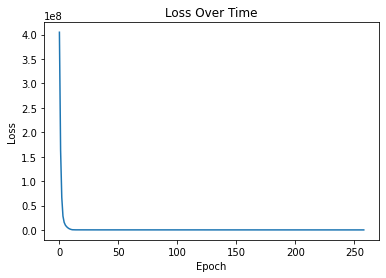

In [218]:
import matplotlib.pyplot as plt

plt.figure()
plt.title('Loss Over Time')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.plot(all_losses)
plt.show()

## Determine Validation Loss

In [219]:
val_dataset = ArgoverseDataset(city = 'all', split = 'val')
val_loader = DataLoader(val_dataset,batch_size=batch_sz)

val_loss = 0
for i_batch, sample_batch in enumerate(val_loader):
    inp, out = sample_batch
    inp = inp.to(device)
    out = out.to(device)
    preds = pred(inp)
    loss = ((preds - out) ** 2).sum()

    val_loss += loss.item()
print('Validation Loss: {}'.format(val_loss / len(val_dataset)))

Validation Loss: 41717.596399136324


## Visualize Sample Predictions on Validation Dataset 

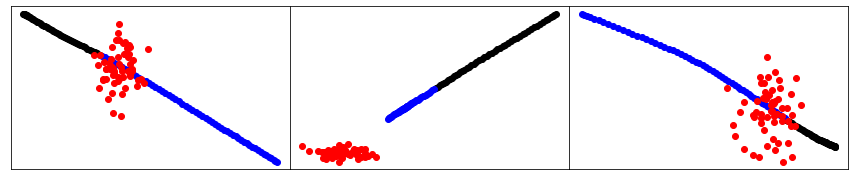

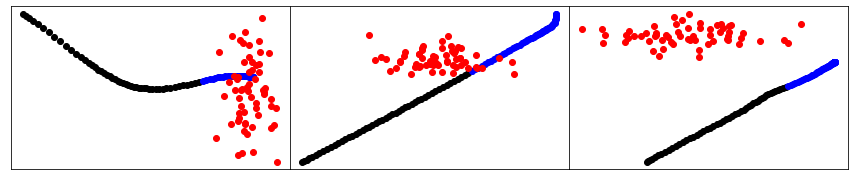

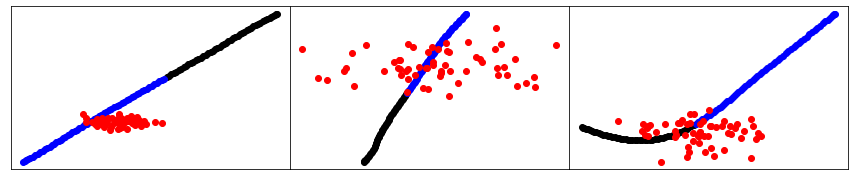

In [246]:
import matplotlib.pyplot as plt
import random

num_samples = 3

val_vis_dataset = ArgoverseDataset(city = 'all', split = 'val')
val_vis_loader = DataLoader(val_dataset,batch_size=3)

def show_sample_batch(sample_batch):
    """visualize the trajectory for a batch of samples"""
    inp, out = sample_batch
    batch_sz = inp.size(0)
    inp = inp.to(device)
    agent_sz = inp.size(1)
    
    fig, axs = plt.subplots(1,batch_sz, figsize=(15, 3), facecolor='w', edgecolor='k')
    fig.subplots_adjust(hspace = .5, wspace=.001)
    axs = axs.ravel()   
    for i in range(batch_sz):
        axs[i].xaxis.set_ticks([])
        axs[i].yaxis.set_ticks([])
        inp = inp.to(device)
        pred_traj = pred(inp)
        pred_traj = pred_traj.cpu().detach().numpy()
        inp = inp.cpu()
        
        # first two feature dimensions are (x,y) positions
        axs[i].scatter(inp[i,:,0], inp[i,:,1], color='black')
        axs[i].scatter(out[i,:,0], out[i,:,1], color='blue')
        axs[i].scatter(pred_traj[i,:,0], pred_traj[i,:,1], color='red')

        
for i_batch, sample_batch in enumerate(val_vis_loader):
    inp, out = sample_batch
    # print(inp.shape, out.shape)
    
    """
    TODO:
      implement your Deep learning model
      implement training routine
    """
    show_sample_batch(sample_batch)

    if (i_batch == (num_samples-1)):
      break

## Calculate Test Predictions and Export to CSV

In [222]:
import pandas as pd

def predictions_to_csv():
    num_pred_steps = 60
    all_preds = np.zeros(shape=(0, num_pred_steps * 2))
    city_col = np.array([])

    print("Calculating Test Trajectory Predictions ...\n")

    print("-----------------------------")

    # Test predictions for ALL cities
    for city_name in cities:

        print("Processing city", city_name)

        # Get Training input values for this city
        test_traj_in, _ = get_city_trajectories(city=city_name, split="test")
        #print(test_traj_in.shape)

        test_pred_arr = []
        # Iterate through all test inputs for this city
        for x in range(len(test_traj_in)):
            # Get the predicted trajectory from the model
            traj_in_tensor = torch.tensor(test_traj_in[x], device=device)
            traj = pred(traj_in_tensor)[0]
            # Add the prediction to the test prediction array
            traj_arr = traj.cpu().detach().numpy()
            test_pred_arr.append(traj_arr)
        test_pred_arr = numpy.array(test_pred_arr)
        # print(test_pred_arr.shape)
    
        # Reshape the predictions to the submission format size (120)
        test_pred_arr_reshaped = np.reshape(test_pred_arr, newshape=(test_traj_in.shape[0], num_pred_steps * 2))
        print(test_pred_arr_reshaped.shape)

        print("-----------------------------")

        # Add to total predictions / columns
        all_preds = np.r_[all_preds, test_pred_arr_reshaped]
        city_col = np.r_[city_col, [str(i) + "_" + city_name for i in range(test_pred_arr.shape[0])]]
    
    # Convert predictions to csv file
    print('\nExporting Predictions ...\n')
    sub_df = pd.DataFrame(np.c_[city_col, all_preds], columns=[np.r_[["ID"], ["v" + str(i) for i in range(120)]]])
    submission_file_name = 'predictions_submission.csv'
    sub_df.to_csv(submission_file_name, index=None)
    print('---------------------------------------------------------------')
    print('|  Test Predictions Exported to ./' + submission_file_name + "  |")
    print('---------------------------------------------------------------')


In [223]:
predictions_to_csv()

Calculating Test Trajectory Predictions ...

-----------------------------
Processing city austin
(6325, 120)
-----------------------------
Processing city miami
(7971, 120)
-----------------------------
Processing city pittsburgh
(6361, 120)
-----------------------------
Processing city dearborn
(3671, 120)
-----------------------------
Processing city washington-dc
(3829, 120)
-----------------------------
Processing city palo-alto
(1686, 120)
-----------------------------

Exporting Predictions ...

---------------------------------------------------------------
|  Test Predictions Exported to ./predictions_submission.csv  |
---------------------------------------------------------------
